# Sampling Measure Zero Polyhedra

We start with a HPolyhedron defined by
$$
    Ax \leq b
$$
$$
    Cx = d
$$

## Defining the original polyhedron P

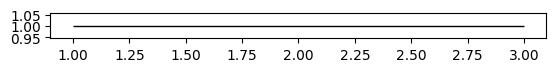

In [1]:
from large_gcs.geometry.polyhedron import Polyhedron
import numpy as np
import matplotlib.pyplot as plt

P_verts = np.array([[1,1],[3,1]])
P = Polyhedron.from_vertices(P_verts)
P._vertices = P_verts
P.plot()

In [2]:
P.set.A()

array([[ 1., -0.],
       [-1.,  0.],
       [ 0.,  1.],
       [-0., -1.]])

In [3]:
P.set.b()

array([ 3., -1.,  1., -1.])

In [4]:
P.has_equality_constraints()

True

In [5]:
A,b,C,d = P.get_separated_inequality_equality_constraints()

In [6]:
A

array([[ 1., -0.],
       [-1.,  0.]])

In [7]:
b

array([ 3., -1.])

In [8]:
C

array([[0., 1.]])

In [9]:
d

array([1.])

## Finding the null space of a matrix

In [10]:
import numpy as np
from scipy.linalg import null_space

# Define your matrix X
X = np.array([
    [1, 2, 3, 5],
    [4, 5, 6, 2],
    [7, 8, 9, 1]
])

# Find the basis for the kernel of X
kernel_basis = null_space(X)

print("Basis for the kernel of X:")
print(kernel_basis)
X @ kernel_basis


Basis for the kernel of X:
[[-4.08248290e-01]
 [ 8.16496581e-01]
 [-4.08248290e-01]
 [-4.99600361e-16]]


array([[-8.8817842e-16],
       [ 0.0000000e+00],
       [-8.8817842e-16]])

### Find the basis of the null space of C

In [11]:
V = null_space(C)
V

array([[-1.],
       [ 0.]])

In [12]:
V.shape

(2, 1)

## Find $x_0$ such that $Cx_0 = d$

In [13]:
# Compute the pseudo-inverse of C
C_pinv = np.linalg.pinv(C)

# Use the pseudo-inverse to find x_0
x_0 = np.dot(C_pinv, d)
x_0

array([0., 1.])

In [14]:
Q = Polyhedron(A = A@V, b = b - A @ x_0)

In [15]:
q_samples = Q.get_samples(20)
q_samples.shape

(20, 1)

In [16]:
V.shape

(2, 1)

In [17]:
p_samples = q_samples @ V.T + x_0
p_samples

array([[1.06226446, 1.        ],
       [2.09444119, 1.        ],
       [2.4059411 , 1.        ],
       [1.99267464, 1.        ],
       [1.42384866, 1.        ],
       [2.48129449, 1.        ],
       [1.34773034, 1.        ],
       [2.36689911, 1.        ],
       [2.01882192, 1.        ],
       [1.42041815, 1.        ],
       [1.97513785, 1.        ],
       [2.99436313, 1.        ],
       [2.08793435, 1.        ],
       [1.24648517, 1.        ],
       [1.11985194, 1.        ],
       [2.16191336, 1.        ],
       [2.53968787, 1.        ],
       [1.02707825, 1.        ],
       [1.30306442, 1.        ],
       [1.53440255, 1.        ]])

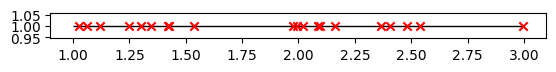

In [18]:
P.plot()
plt.scatter(p_samples[:,0], p_samples[:,1], c = 'r', marker='x')

Now that we've built in this functionality into the `Polyhedron` class, can simply call `get_samples`

In [19]:
samples = P.get_samples(20)
len(samples)
samples

array([[1.06226446, 1.        ],
       [2.09444119, 1.        ],
       [2.4059411 , 1.        ],
       [1.99267464, 1.        ],
       [1.42384866, 1.        ],
       [2.48129449, 1.        ],
       [1.34773034, 1.        ],
       [2.36689911, 1.        ],
       [2.01882192, 1.        ],
       [1.42041815, 1.        ],
       [1.97513785, 1.        ],
       [2.99436313, 1.        ],
       [2.08793435, 1.        ],
       [1.24648517, 1.        ],
       [1.11985194, 1.        ],
       [2.16191336, 1.        ],
       [2.53968787, 1.        ],
       [1.02707825, 1.        ],
       [1.30306442, 1.        ],
       [1.53440255, 1.        ]])

# Check that it works for contact sets with equality constraints

100%|██████████| 52/52 [00:00<00:00, 5032.74it/s]


[array([   2.        ,    2.        ,   -1.5       ,   -1.5       ,
          2.76666955,    2.76666955,   -2.49998453,   -2.49998453,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        , 1000.        , 1000.        ,    0.        ]), array([   2.        ,    2.        ,   -1.5       ,   -1.5       ,
          2.76666955,    2.76666955,   -2.49998453,   -2.49998453,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        , 1000.        , 1000.        ,    0.        ]), array([   2.        ,    2.        ,   -1.5       ,   -1.5       ,
          2.76666955,    2.76666955,   -2.49998453,   -2.49998453,
          0.        ,    0.        ,    0.        ,    0.        ,
          0.        , 1000.        , 1000.        ,    0.        ]), array([   2.        ,    2.        ,   -1.5       ,   -1.5       ,
          2.76666955,    2.76666955,   -2.49998453,   -2.49998453,
          0.        ,    0.        ,    0.        ,    

IndexError: list index out of range

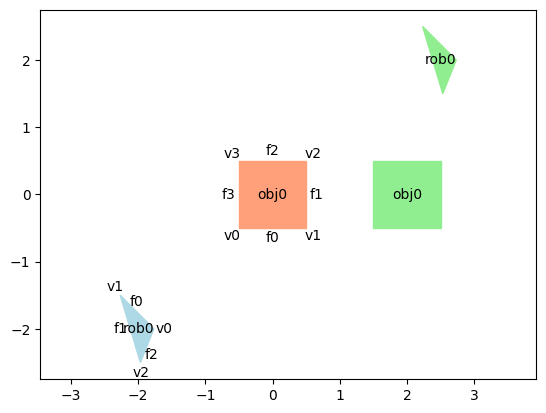

In [20]:
from large_gcs.graph.contact_graph import ContactGraph
from large_gcs.graph_generators.contact_graph_generator import ContactGraphGeneratorParams


graph_file = ContactGraphGeneratorParams.graph_file_path_from_name("cg_simple_2")
cg = ContactGraph.load_from_file(graph_file)
cg.plot()
v = cg.vertex_names[0]
# samples = cg.vertices[v].convex_set.get_samples(20)
cg.plot_samples_in_set(v, 5)